<a href="https://colab.research.google.com/github/rittikarijhwani/movie-recommendation-system/blob/main/movie_rec_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model, Sequential
from pathlib import Path
import matplotlib.pyplot as plt
import pickle

In [5]:
# First, load the data and apply preprocessing

# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)


978202/978202 [==============================] - 0s 0us/step
Extracting all the files now...
Done!


In [6]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
#extracts ids and converts it into a list, encodes id to index in list for user and movies
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
#adds encoded index columns to df
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

In [8]:
df.head()

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4


In [9]:
num_users = len(user2user_encoded)
num_movies = len(movie2movie_encoded)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating))


Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [10]:
#Random Train-Test split
df = df.sample(frac=1, random_state=42) # randomly shuffles dataset to ensure that model does not learn patterns specific to the data order
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [11]:
x_train.shape

(90752, 2)

In [12]:
y_train.shape

(90752,)

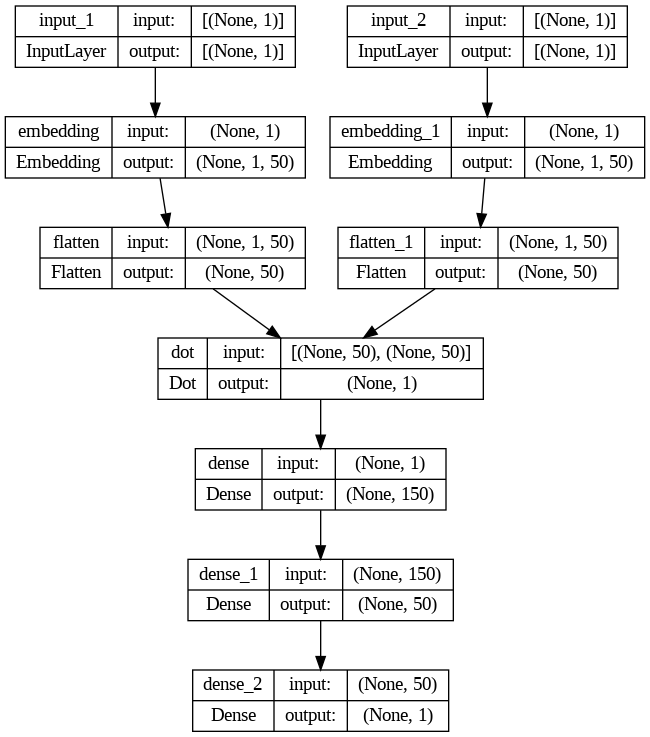

In [13]:
#defining the model
embedding_size = 50

#vectors capture the underlying preferences of users and the characteristics of movies.
user_ips= layers.Input(shape=[1])
user_embedding = layers.Embedding(num_users,embedding_size)(user_ips)
# Embedding layer will create 610 vectors look-up table of 50 dimension each
user_vect= layers.Flatten()(user_embedding)

movie_ips= layers.Input(shape=[1])
movie_embedding = layers.Embedding(num_movies, embedding_size)(movie_ips)
movie_vect= layers.Flatten()(movie_embedding)

#calculates the dot product
prod = layers.dot(inputs=[user_vect, movie_vect],axes=1)

dense1= layers.Dense(150, activation='relu')(prod)
dense2= layers.Dense(50, activation='relu')(dense1)
dense3= layers.Dense(1,activation='relu')(dense2)

#compiling model
model = Model([user_ips, movie_ips], dense3)
model.compile(optimizer='adam',loss='mean_squared_error')

#creating model diagram
keras.utils.plot_model(model,show_shapes=True)

In [14]:
history = model.fit([x_train[:,0], x_train[:,1]], y_train, batch_size=64,epochs=10,verbose=1)

Epoch 1/10
1418/1418 [==============================] - 12s 6ms/step - loss: 0.4988
Epoch 2/10
1418/1418 [==============================] - 6s 4ms/step - loss: 0.4988
Epoch 3/10
1418/1418 [==============================] - 5s 3ms/step - loss: 0.4988
Epoch 4/10
1418/1418 [==============================] - 5s 4ms/step - loss: 0.4988
Epoch 5/10
1418/1418 [==============================] - 5s 4ms/step - loss: 0.4988
Epoch 6/10
1418/1418 [==============================] - 5s 3ms/step - loss: 0.4988
Epoch 7/10
1418/1418 [==============================] - 6s 4ms/step - loss: 0.4988
Epoch 8/10
1418/1418 [==============================] - 5s 4ms/step - loss: 0.4988
Epoch 9/10
1418/1418 [==============================] - 6s 4ms/step - loss: 0.4988
Epoch 10/10
1418/1418 [==============================] - 5s 4ms/step - loss: 0.4988


In [15]:
pred=model.predict([x_train[4:5,0], x_train[4:5,1]])
pred

1/1 [==============================] - 0s 94ms/step


array([[0.]], dtype=float32)

In [16]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [17]:
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[ ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]

In [18]:
user_id

18

In [19]:
movies_watched_by_user.head()

,userId,movieId,rating,timestamp,user,movie
2174,18,86190,3.5,1456924897,17,1323
2086,18,48516,4.5,1455049826,17,237
1938,18,2692,3.0,1455231448,17,178
1956,18,3751,3.5,1455529841,17,1186
2168,18,80489,4.0,1463686312,17,245


In [22]:
## basically inner join between movies_not_watched and movie ids from df table (to be sure that the movie ids are not out of scope)
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)


In [23]:
movies_not_watched_index = [[movie2movie_encoded.get(x)] for x in movies_not_watched]  # get the indexes of the movies not watched by the user


In [24]:
user_encoder = user2user_encoded.get(user_id)
user_encoder

17

In [25]:
user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched_index))
user_movie_array ## 1st column is user_index and 2nd col is the list of movie indexes not watched by the user

array([[  17, 5804],
       [  17,    1],
       [  17,  482],
       ...,
       [  17, 3870],
       [  17, 2989],
       [  17, 7869]])

In [26]:
ratings = model.predict([user_movie_array[:,0],user_movie_array[:,1]]).flatten()
ratings

289/289 [==============================] - 1s 2ms/step


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [27]:
top_ratings_indices = ratings.argsort()[-10:][::-1] # indices of highest 10 ratings

In [28]:
recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched_index[x][0]) for x in top_ratings_indices]

In [29]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 18
Movies with high ratings from user
--------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Shawshank Redemption, The (1994) : Crime|Drama
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) : Action|Adventure|Western
12 Angry Men (1957) : Drama
Once Upon a Time in the West (C'era una volta il West) (1968) : Action|Drama|Western


In [30]:
print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


--------------------------------
Top 10 movie recommendations
--------------------------------
Phantasm III: Lord of the Dead (1994) : Horror
Phantasm IV: Oblivion (1998) : Horror
Pumpkinhead (1988) : Horror
Air America (1990) : Action|Comedy
Sleepaway Camp (1983) : Horror
Steel Magnolias (1989) : Drama
And God Created Woman (Et Dieu... créa la femme) (1956) : Drama
Easy Money (1983) : Comedy
Swordfish (2001) : Action|Crime|Drama
Deadfall (2012) : Crime|Drama|Thriller
